## NinaPro动作分类——多模态学习方法

LMF（Low-rank Multimodal Fusion）出自论文 Efficient Low-rank Multimodal Fusion with Modality-Specific Factors，ACL2018。是TFN的等价升级版，就具体模型如图。LMF利用对权重进行低秩矩阵分解，将TFN先张量外积再FC的过程变为每个模态先单独线性变换之后再多维度点积，可以看作是多个低秩向量的结果的和，从而减少了模型中的参数数量。

#### 1.数据读取与预处理

In [1]:
from scipy import io
import numpy as np

def get_feature_dict(filename):
    """将ninapro_feature的MAT文件加载为字典

    Args:
        path: mat文件路径

    Returns:
        数据集字典
        [feat_set, featStim, featRep]
    """
    # 读取MAT文件
    print('load file: ' + filename + '...', end= '', flush=True)
    dict_feature=io.loadmat(filename)
    if (dict_feature != ()):
        #print(ninapro_data.keys())
        print('[ok]:%d'%(len(dict_feature['featStim'])), flush=True)
    # 返回字典
    return dict_feature


In [2]:
def split_zeros(feature_dict,feature_name,channels):
    """将ninapro_feature数据集中【restimulate】为0的部分（受试者不做动作）从数据集中去除

    Args:
        feature_dict: 数据集字典
        feature_name: 待处理的数据的keyvalue
        channels: 待处理的数据的通道数

    Returns:
        [feature_split, labels] 去除0部分的数据，对于的label(numpy array)
    """
    feature_split = None
    index = []
    for i in range(len(feature_dict['featStim'])):
        if feature_dict['featStim'][i]!=0:
            index.append(i)
    # 重排元素
    emg_temp = feature_dict[feature_name]
    emg_temp = np.reshape(emg_temp,(-1,5,channels))
    emg_temp = np.swapaxes(emg_temp,1,2)
    # 去除0label
    if(feature_split is None):
        feature_split = emg_temp[index,:,:]
        labels = feature_dict['featStim'][index,:]
    else:
        feature_split = np.vstack((feature_split,emg_temp[index,:,:])) 
        labels = np.vstack((labels,feature_dict['featStim'][index,:]))
    return feature_split, labels

# 对多组数据合并，预处理
def merge_multisubject(b,e):
    """将多组数据从mat文件中提取出来，预处理后合并

    Args:
        b: 开始的受试者序号
        e: 结束的受试者序号

    Returns:
        [emg,acc,gyro,mag,labels]肌电c12，加速度c36，角速度c36，磁强c36数据和标签。
    """
    emg_feature = None
    labels = None
    # 遍历受试者序号
    for i in range(b,e+1):
        emg_dict = get_feature_dict("../feature/feature_S{0}.mat".format(i))
        imu_dict = get_feature_dict("../feature/IMU_feature_S{0}.mat".format(i))
        # 寻找动作为0的元素并剔除
        emg,labels = split_zeros(emg_dict,'feat_set',12)
        acc,labels = split_zeros(imu_dict,'acc_feat',36)
        gyro,labels = split_zeros(imu_dict,'gyro_feat',36)
        mag,labels = split_zeros(imu_dict,'mag_feat',36)
        #print('delete 0 label,',emg_temp[index,:,:].shape)
    # s = [1.28889041e-05, 0.00000000e+00, 1.72402617e+01, 1.57331247e+01, 2.11883893e-03]
    # 归一化
    # for i in range(5):
    #     #s[i] = np.sum(np.abs(emg_feature[:,:,i]))/emg_feature[:,:,i].size
    #     #print("avg=",s)
    #     if(s[i]!=0):
    #         emg_feature[:,:,i] /= s[i]
    #         emg_feature[:,:,i] -= 0.5*s[i]
    return emg,acc,gyro,mag,labels

# 读取2组数据分布作训练集和验证集
emg_feature,acc_feature,gyro_feature,mag_feature,labels = merge_multisubject(1,1)
feat_set = np.concatenate((emg_feature,acc_feature,gyro_feature,mag_feature),axis = 1)

emg_feature,acc_feature,gyro_feature,mag_feature,labels_test = merge_multisubject(2,2)
feat_set_test = np.concatenate((emg_feature,acc_feature,gyro_feature,mag_feature),axis = 1)
print(feat_set.shape,labels.shape)



load file: ../feature/feature_S1.mat...[ok]:206751
load file: ../feature/IMU_feature_S1.mat...[ok]:206751
load file: ../feature/feature_S2.mat...[ok]:206659
load file: ../feature/IMU_feature_S2.mat...[ok]:206659
(97210, 120, 5) (97210, 1)


In [3]:
#数据预处理
def precess_data(feat,label):
    """将数据reshape到可以送入神经网络的size

    Args:
        feat: 特征序列
        label: 标签

    Returns:
        [feat, label] 处理后的特征序列和标签
    """
    feat = np.swapaxes(feat,1,2)
    feat = np.expand_dims(feat,1)
    feat = feat.astype(np.float32)
    label = label.flatten() - 1
    return feat,label
feat_set,labels = precess_data(feat_set,labels)
feat_set_test,labels_test = precess_data(feat_set_test,labels_test)

print(feat_set.shape,labels.shape)
print(feat_set_test.shape,labels_test.shape)

(97210, 1, 5, 120) (97210,)
(105147, 1, 5, 120) (105147,)


#### 2.模型建立

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F
from torchvision import models
from torch.nn.parameter import Parameter

class LFM_net(nn.Module):
    """LFM实现的卷积神经网络
    """
    def __init__(self, class_num=40):
        super(LFM_net, self).__init__()
        self.class_num = class_num

        self.res18 = models.resnet18(num_classes=class_num)
        self.res18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def LFM_fushion(self, x, R = 4, h = 24):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        A = x[:,:,0:12].view(5,12).to(device)
        B = x[:,:,12:].view(5,108).to(device)
        
        n = A.shape[0]
        A = torch.cat([A, torch.ones(n, 1).to(device)], dim=1).float().to(device)
        B = torch.cat([B, torch.ones(n, 1).to(device)], dim=1).float().to(device)

        
        
        Wa = Parameter(torch.Tensor(R, A.shape[1], h)).to(device)
        Wb = Parameter(torch.Tensor(R, B.shape[1], h)).to(device)
        Wf = Parameter(torch.Tensor(1, R)).to(device)
        bias = Parameter(torch.Tensor(1, h)).to(device)

        fusion_A = torch.matmul(A, Wa).to(device)
        fusion_B = torch.matmul(B, Wb).to(device)

        funsion_AB = fusion_A * fusion_B
        funsion_AB = torch.matmul(Wf, funsion_AB.permute(1,0,2)).squeeze() + bias
        funsion_AB = funsion_AB.unsqueeze(0)
        return funsion_AB    

    def forward(self, x):
        #print(x.size())
        xf = torch.zeros(x.shape[0],5,24)
        for i in range(x.shape[0]):
            xf[i] = self.LFM_fushion(x[i],R=4,h=24)
        # 假设所设秩: R = 4, 期望融合后的特征维度: h = 24
        x = self.res18(x)
        return x

# 输出网络结构
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
model_test = LFM_net(class_num=40).to(device)
summary(model_test,(1,5,120))

The model will be running on cuda:0 device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 3, 60]           3,136
       BatchNorm2d-2            [-1, 64, 3, 60]             128
              ReLU-3            [-1, 64, 3, 60]               0
         MaxPool2d-4            [-1, 64, 2, 30]               0
            Conv2d-5            [-1, 64, 2, 30]          36,864
       BatchNorm2d-6            [-1, 64, 2, 30]             128
              ReLU-7            [-1, 64, 2, 30]               0
            Conv2d-8            [-1, 64, 2, 30]          36,864
       BatchNorm2d-9            [-1, 64, 2, 30]             128
             ReLU-10            [-1, 64, 2, 30]               0
       BasicBlock-11            [-1, 64, 2, 30]               0
           Conv2d-12            [-1, 64, 2, 30]          36,864
      BatchNorm2d-13            [-1, 64, 2, 30]             

In [5]:
import time

def testAccuracy(device, model, test_loader):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            emg_data, labels = data
            emg_data = Variable(emg_data.to(device))    # torch.Size([64, 1, 200, 12])
            labels = Variable(labels.to(device))        # torch.Size([64])
            # run the model on the test set to predict labels
            outputs = model(emg_data)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

train_accs = []
train_loss = []
test_accs = []

def train(device, num_epochs, train_loader, test_loader):
    best_accuracy = 0
    # model = models.resnet18(num_classes=40)
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # model = model.to(device)
    model = LFM_net(class_num=40).to(device)
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    
    

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i,(inputs, labels) in enumerate(train_loader,0):#0是下标起始位置默认为0
            
            inputs = Variable(inputs.to(device))    
            labels = Variable(labels.to(device))    
            #初始为0，清除上个batch的梯度信息
            optimizer.zero_grad()         

            #前向+后向+优化     
            outputs = model(inputs)
            loss = loss_func(outputs,labels.long())
            loss.backward()
            optimizer.step()

            # loss 的输出，每个一百个batch输出，平均的loss
            running_loss += loss.item()
            if i%100 == 99:
                print('[%d,%5d] loss :%.3f' %
                    (epoch+1,i+1,running_loss/100),end='',flush=True)
                running_loss = 0.0
            train_loss.append(loss.item())

            # 训练曲线的绘制 一个batch中的准确率
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)# labels 的长度
            correct = (predicted == labels).sum().item() # 预测正确的数目
            train_accs.append(100*correct/total)
            if i%100 == 99:
                print(' acc=%d'%(100*correct/total))
            
        accuracy = testAccuracy(device, model, test_loader)
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "../model/best_epoch{1}_{0}.pth".format(epoch, (int(time.time())%1000000)))

In [6]:
labels_t = torch.tensor(labels)
feat_set_t = torch.tensor(feat_set)
dataset = torch.utils.data.TensorDataset(feat_set_t, labels_t)

labels_test_t = torch.tensor(labels_test)
feat_set_test_t = torch.tensor(feat_set_test)
dataset_test = torch.utils.data.TensorDataset(feat_set_test_t, labels_test_t)

# split_ratio = 0.25
# test_length = int(0.25*len(labels))
# train_length = len(labels)-test_length
# train_dataset,test_dataset = torch.utils.data.random_split(
#     dataset = dataset,
#     lengths = [train_length,test_length]
# )

print('get dataloader...', end='',flush=True)
# 划分数据集与训练集
train_loader = torch.utils.data.DataLoader(
    dataset=dataset,      # torch TensorDataset format
    batch_size=256,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
    drop_last = True,
   
)
test_loader = torch.utils.data.DataLoader(
    dataset=dataset_test,      # torch TensorDataset format
    batch_size=256,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
    drop_last = True,
)
print('[ok]')


get dataloader...[ok]


In [7]:
print('begin to train.....')
# 模型训练
train(device, 10, train_loader, test_loader)

begin to train.....
[1,  100] loss :0.982 acc=92
[1,  200] loss :0.224 acc=95
[1,  300] loss :0.128 acc=95
For epoch 1 the test accuracy over the whole test set is 8 %
[2,  100] loss :1.148 acc=83
[2,  200] loss :0.275 acc=92
[2,  300] loss :0.210 acc=95
For epoch 2 the test accuracy over the whole test set is 12 %
[3,  100] loss :0.125 acc=95
[3,  200] loss :0.110 acc=95
[3,  300] loss :0.095 acc=97
For epoch 3 the test accuracy over the whole test set is 13 %
[4,  100] loss :0.075 acc=94
[4,  200] loss :0.061 acc=98
[4,  300] loss :0.104 acc=99
For epoch 4 the test accuracy over the whole test set is 11 %
[5,  100] loss :0.040 acc=99
[5,  200] loss :0.064 acc=98
[5,  300] loss :0.042 acc=98
For epoch 5 the test accuracy over the whole test set is 11 %
[6,  100] loss :0.036 acc=98
[6,  200] loss :0.031 acc=100
[6,  300] loss :0.033 acc=98
For epoch 6 the test accuracy over the whole test set is 8 %
[7,  100] loss :0.045 acc=99
[7,  200] loss :0.026 acc=98
[7,  300] loss :0.043 acc=98


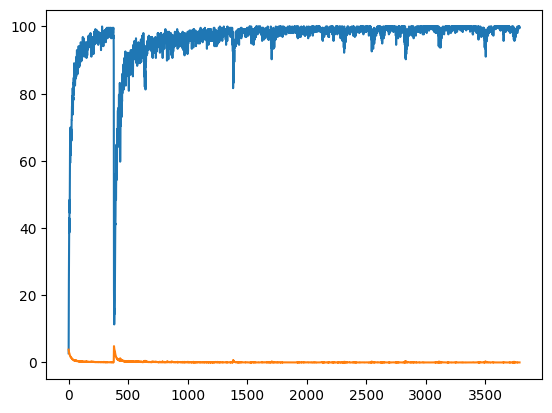

In [11]:
import matplotlib.pyplot as plt
train_loss = np.array(train_loss)
train_accs = np.array(train_accs)
plt.plot(train_accs)
plt.plot(train_loss)
np.savetxt('train_loss2.csv', train_loss, delimiter=",")
np.savetxt('train_accs2.csv', train_accs, delimiter=",")